In [1]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

## Model Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC

In [2]:
## Tuned params
params = {'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 8,
 'missing': None,
 'monotone_constraints': None,
 'n_estimators': 12,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'nthread': 4,
 'seed': 27,
 'tree_method': 'hist'}

In [3]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv").iloc[:,1:]
df = df.drop_duplicates(subset='website')

In [4]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [5]:
# trained_tf_idf_df = df[(df.label == 'APPROVED') & (df.tnc_refund_policy_exist == 1)]\
# .sample(n=50, replace=False, random_state=50)
# trained_tf_idf_df.to_csv("train_tf_idf.csv", index=False)
# df = df[~df.website.isin(trained_tf_idf_df.website)]

In [6]:
# df.groupby("label").size()

In [7]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [8]:
X = df.iloc[:, 1:8]
# X = df.iloc[:, 2:8]

## Train/Test Split

In [9]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
## Gaussian Naive Bayes has a good ability to predict REJECTED websites, but it is hard to got a low FP Rate with this model.
## While XGBoost provides more reliable model with low FP rate and enough TP rate
## Though, it goes back to the business decision which rate is more important

model_choice = GaussianNB()
# model_choice = BernoulliNB()
# model_choice = MultinomialNB()
# model_choice = XGBClassifier(**params)

In [12]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [13]:
# ## Using the best TPR threshold
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.6310040696227789).astype(bool)

In [14]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

In [15]:
y_pred_proba = clf.predict_proba(X_test)

In [16]:
np.round(accuracy_score(y_test, y_pred), 2)

0.86

In [17]:
y_train.value_counts(), y_test.value_counts()

(0    141
 1     54
 Name: label, dtype: int64,
 0    74
 1    23
 Name: label, dtype: int64)

In [18]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [19]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.87, 0.149)

In [20]:
tn, fp, fn, tp

(63, 11, 3, 20)

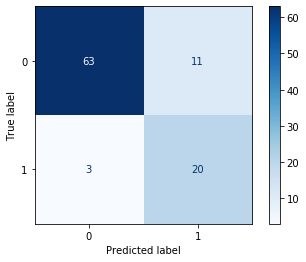

In [21]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [23]:
auc_score = auc(fpr, tpr)

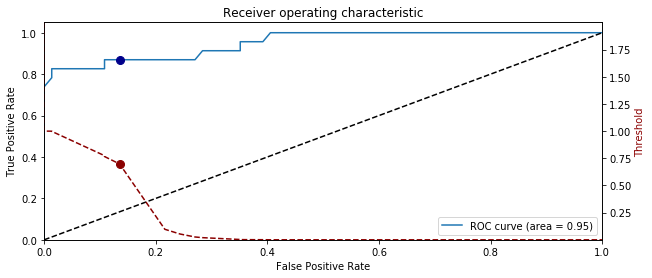

 -- Optimum Threshold -- 
        fpr       tpr     1-fpr      tf  thresholds
6  0.135135  0.869565  0.864865  0.0047    0.697484


In [24]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# find optimum thresholds
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkblue')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
ax2.set_ylabel('Threshold',color='darkred')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])
ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
print(" -- Optimum Threshold -- ")
print(df_thresh)

In [25]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 1.9998965813771563
TPR 0.7391304347826086, FPR 0.0, Threshold 0.9998965813771564
TPR 0.782608695652174, FPR 0.013513513513513514, Threshold 0.998894731290706
TPR 0.8260869565217391, FPR 0.013513513513513514, Threshold 0.9974152591246527
TPR 0.8260869565217391, FPR 0.10810810810810811, Threshold 0.7738980778512773
TPR 0.8695652173913043, FPR 0.10810810810810811, Threshold 0.7658563238496804
TPR 0.8695652173913043, FPR 0.13513513513513514, Threshold 0.6974840107669086
TPR 0.8695652173913043, FPR 0.21621621621621623, Threshold 0.09663738214847684
TPR 0.8695652173913043, FPR 0.24324324324324326, Threshold 0.05344330022682471
TPR 0.8695652173913043, FPR 0.2702702702702703, Threshold 0.025992385231477275
TPR 0.9130434782608695, FPR 0.28378378378378377, Threshold 0.019662597680987073
TPR 0.9130434782608695, FPR 0.35135135135135137, Threshold 0.0027681744904294483
TPR 0.9565217391304348, FPR 0.35135135135135137, Threshold 0.0017736390955103

## Bootstrapped

In [ ]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

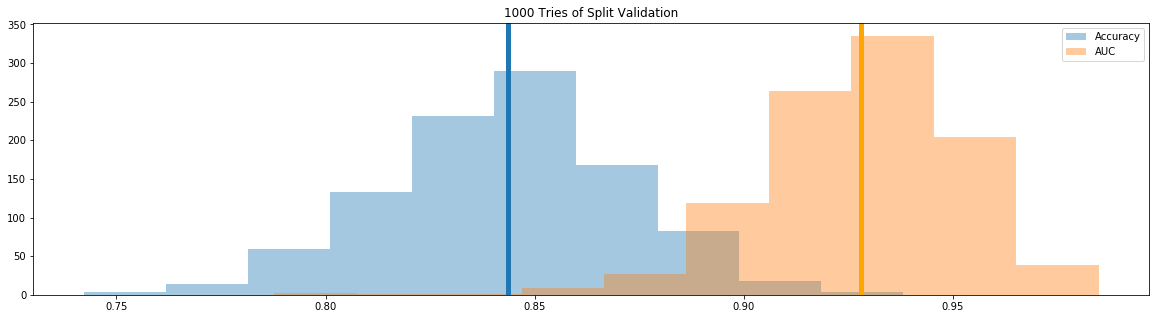

Accuracy mean: 0.84
AUC mean: 0.93


In [27]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Model Comparison

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
## Initiate models
models = []
models.append(('K-Nearest Neighbour', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Bernoulli Naive Bayes', BernoulliNB()))
models.append(('Multinomial Naive Bayes', MultinomialNB()))
models.append(('XGBoost Classifier', XGBClassifier(**params)))

In [30]:
## Results
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    ## AUC Scoring
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    print('%s: \nAUC Mean %f, STD %f\n'%(name, cv_results.mean(), cv_results.std()))

K-Nearest Neighbour: 
AUC Mean 0.875640, STD 0.030679

Decision Tree Classifier: 
AUC Mean 0.830974, STD 0.054526

Gaussian Naive Bayes: 
AUC Mean 0.920376, STD 0.045295

Bernoulli Naive Bayes: 
AUC Mean 0.924758, STD 0.049689

Multinomial Naive Bayes: 
AUC Mean 0.912342, STD 0.033855

XGBoost Classifier: 
AUC Mean 0.884055, STD 0.053829



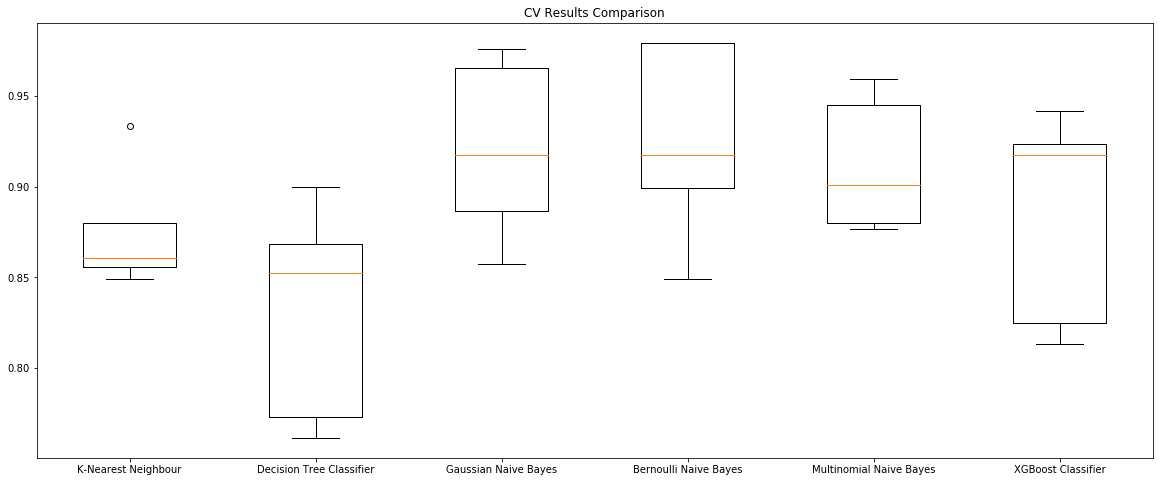

In [31]:
## Results Distribution
plt.figure(figsize=(20,8))
plt.boxplot(results, labels=names)
plt.title('CV Results Comparison')
plt.show()

## Dump To Pickle

In [32]:
clf = model_choice
clf = clf.fit(X, y)
pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

In [33]:
# feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.show()